In [1]:
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
from scipy import interpolate
from MyUnit import SIUnit, NaturalUnit
from scipy.interpolate import interp1d

# choose the specific CLASS version
# classy_path = '/a/home/cc/students/physics/chensun/tomerv_storage/Code/class_axion/python/build/lib.linux-x86_64-2.7'
import sys
#sys.path.insert(1, classy_path)
from classy import Class

import classy
classy.__file__


'/home/chen/anaconda3/envs/py38/lib/python3.8/site-packages/classy.cpython-38-x86_64-linux-gnu.so'

In [2]:
def joinstring(list):
    res = ""
    for x in list[:-1]:
        res = res+str(x)+","
    res = res + str(list[-1])
    return res

# test = [1.,3.,7.,10.]
# joinstring(test)
# '1.0,3.0,7.0,10.0'

In [3]:
# np.sqrt(6.)
# # 2.449489742783178

<IPython.core.display.Javascript object>


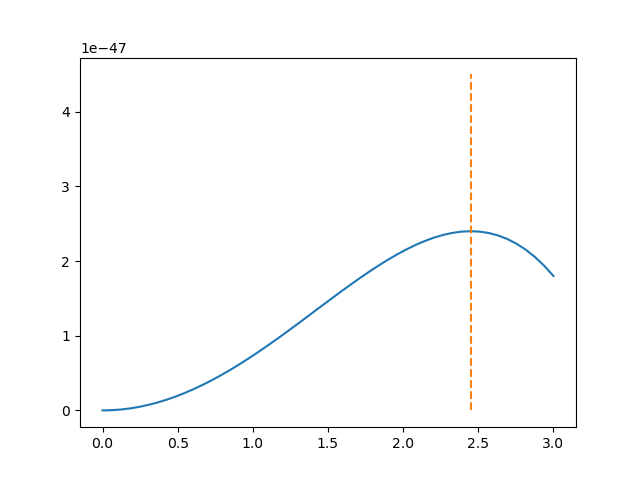

In [4]:
# draw the potential
_eV_Mpc_=1.5637496259e29;
_sqrt_8pi_=5.013256549;
f=4e-4 # in Mpl,r units
m=1e-20 # in eV units
#phi_ini = (np.sqrt(6)-1e-3)*f
#phi_ini = (np.sqrt(6)-1e-6)*f
phi_ini = (np.sqrt(6)-5e-7)*f

# the following crashes the code due to stiffness
# in the new CLASS 3 background.c has the option to 
# use the ndf15 evolver
# TODO: fast-forward merge it to the new CLASS version
#phi_ini = (np.sqrt(6)-1e-10)*f

def V(phi):
    return 1./2.*m**2*phi**2 - 1./24.*m**2/f**2*phi**4
phi_list = np.linspace(0.,3.)
plt.subplots()
plt.plot(phi_list, V(phi_list*f))

V_list = np.linspace(0,1.5)
plt.plot([np.sqrt(6)]*50,V_list*3e-47, '--')
# hill top corresponds to 
# phi = sqrt(6) f

In [5]:
# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
    #'gauge':'synchronous',
    'gauge':'newtonian',
    'input_verbose' : 1,
    'background_verbose' : 2,
    'thermodynamics_verbose': 1,
    'perturbations_verbose': 2,
    'h': 0.673,
    'omega_b': 0.02205,
    #'omega_cdm': 0.1199,
    'omega_cdm': 0.01,
    'tau_reio': 0.089,
    'A_s':math.exp(3.089)*10**-10,
    'n_s':0.9603,
    'N_ur' : 2.03351,
    'N_ncdm' : 1,
    'm_ncdm' : 0.06,
    'T_ncdm' : 0.715985, 
    'T_cmb' : 2.2755,
    ## Output setup
    #'lensing': 'yes',
    #'l_max_scalars': 3000, 
    #'output': 'tCl,pCl,lCl,mPk',
    #'output': 'mTk, vTk',
    #'compute damping scale': 'Y'
    #'k_output_values':'1.,7.,70.'
}

#k_list = [0.01,10.,1000.]
k_crit = 75.35
k_list = [k_crit/20.,k_crit, k_crit*2.]
# k_list = np.arange(1.,60, 10.)
# k_list = np.arange(1.,3.,0.5)

settings_scf = {
    'phi_ini_scf': phi_ini,
    'scf_m': m,
    'scf_f': f,
    'scf_w': 0,
    'scf_phiprime_ini': 1e-50,
    'scf_tau_end_over_tau_crit': 8.,
    'output': 'mTk, vTk',
    'k_output_values':'%s' %(joinstring(k_list)),
    'P_k_max_1/Mpc': 1e-5 # need to set this otherwise most of the time is spend on computing k ~ 0-1
}

try:
    cosmo.struct_cleanup()
except:
    pass
# Create an instance of the CLASS wrapper
cosmo = Class()

# Set the parameters to the cosmological code
cosmo.set(params)
cosmo.set(settings_scf)
cosmo.compute()

print(cosmo.age())

12.59585547749632


In [7]:
# # debugging
# import matplotlib
# %matplotlib notebook
# import numpy as np
# import matplotlib.pyplot as plt


# plt.subplots()
# plt.yscale('log')
# plt.xscale('log')
# path = '/a/home/cc/students/physics/chensun/tomerv_storage/Code/class_axion/test_phi_of_tau_after.txt'
# data = []
# with open(path, 'r') as f:
#     for line in f:
#         line_list = line.split()
#         data.append(line_list)
# data = np.asarray(data)
# data = data.astype(float)
# plt.plot(data[:,0], np.abs(data[:,1]), '.',markersize=.1)

# # plt.subplots()
# # plt.yscale('log')
# # plt.xscale('log')
# # path = '/a/home/cc/students/physics/chensun/tomerv_storage/Code/class_axion/test_V_of_tau_after.txt'
# # data = []
# # with open(path, 'r') as f:
# #     for line in f:
# #         line_list = line.split()
# #         data.append(line_list)
# # data = np.asarray(data)
# # data = data.astype(float)
# # plt.plot(data[:,0], np.abs(data[:,1]), '.',markersize=.1)
# # end of debugging

In [8]:
background = cosmo.get_background()
print('----background keys: ')
print(background.keys())
print('\n\n')

thermodynamics = cosmo.get_thermodynamics()
print('----thermodynamics keys: ')
print(thermodynamics.keys())
print('\n\n')

perturbations = cosmo.get_perturbations()
print('----perturbations keys: ')
print(perturbations['scalar'][0].keys())
print('\n\n')

# print '----CMB power spectra keys: '
# print cosmo.lensed_cl(3000).viewkeys()
# print '\n\n'

# z_rec = cosmo.get_current_derived_parameters(['z_rec'])['z_rec']
# print z_rec

z_eq = cosmo.get_current_derived_parameters(['z_eq'])['z_eq']
print("z_eq=%g" %z_eq)

# tau_eq = np.interp(z_eq, background['z'], background['conf. time [Mpc]'])
tau_eq = interp1d(background['z'], background['conf. time [Mpc]'], kind='cubic')(z_eq)
print("tau_eq=%g" %tau_eq)

----background keys: 
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_scf', '(.)p_scf', '(.)p_prime_scf', 'phi_scf', "phi'_scf", 'V_scf', "V'_scf", "V''_scf", '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])



----thermodynamics keys: 
dict_keys(['z', 'conf. time [Mpc]', 'x_e', "kappa' [Mpc^-1]", 'exp(-kappa)', 'g [Mpc^-1]', 'Tb [K]', 'w_b', 'c_b^2', 'tau_d'])



----perturbations keys: 
dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_ncdm[0]', 'theta_ncdm[0]', 'shear_ncdm[0]', 'cs2_ncdm[0]', 'delta_scf', 'theta_scf'])



z_eq=9645.54
tau_eq=57.1037


In [9]:
# estimate of k_crit

m_Mpc = m*_eV_Mpc_
tau_crit = np.sqrt(2./m_Mpc*tau_eq*(1.+z_eq))
a_crit = np.sqrt(2./(1.+z_eq)/m_Mpc/tau_eq)
z_crit = 1./a_crit - 1.
k_crit = m_Mpc * a_crit
print('k_crit = %g'%(k_crit))
print('a_crit = %g'%(a_crit))

k_crit = 75.3495
a_crit = 4.81852e-08


## Background

<IPython.core.display.Javascript object>


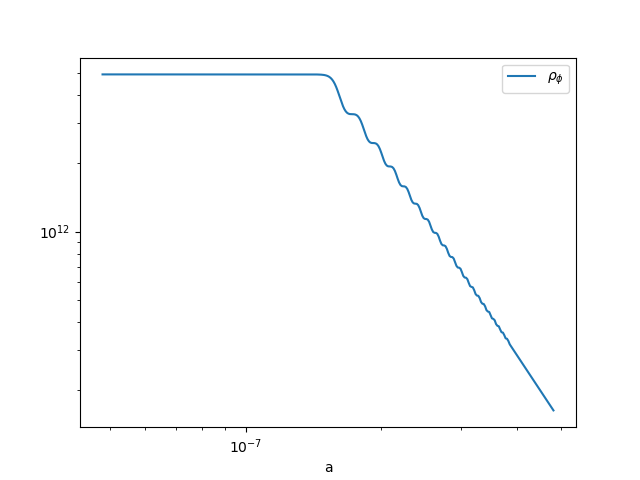

In [10]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('a')
a_list = 1/(1+background['z'])
mask1=a_list > a_crit
mask2=a_list < 10.*a_crit
mask=mask1*mask2
plt.plot(a_list[mask], background['(.)rho_scf'][mask], '-', label=r"$\rho_{\phi}$")
plt.legend(loc='best')
#plt.xlim(5e-8, 1e-5)
#plt.ylim(1e4, 1e11)

<IPython.core.display.Javascript object>


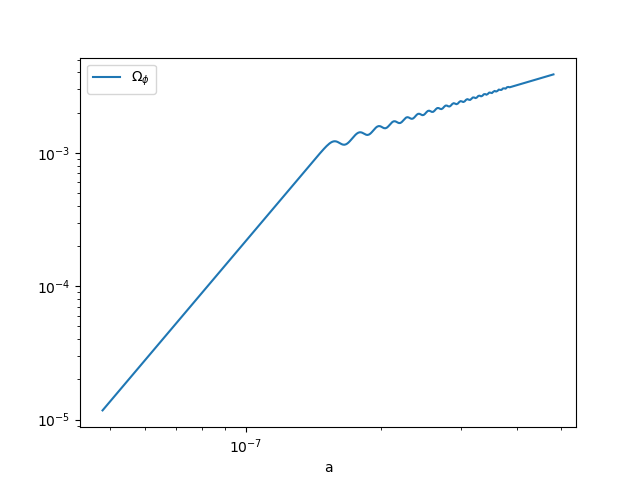

In [11]:
plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('a')
plt.plot(1/(1+background['z'][mask]), background['(.)rho_scf'][mask]/background['(.)rho_tot'][mask], '-', label=r"$\Omega_{\phi}$")
plt.legend(loc='best')

<IPython.core.display.Javascript object>


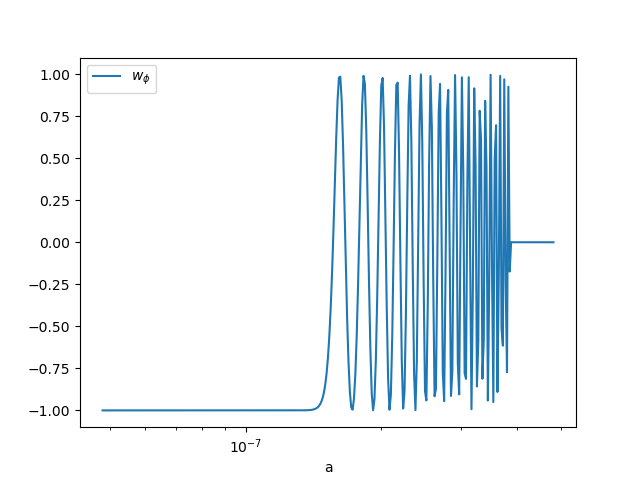

In [12]:
plt.subplots()
plt.xscale('log')
plt.xlabel('a')
plt.plot(1/(1+background['z'][mask]), background['(.)p_scf'][mask]/background['(.)rho_scf'][mask], '-', label=r"$w_{\phi}$")
plt.legend(loc='best')
#plt.xlim(5e-8, 1e-4)
#plt.ylim(1e4, 1e11)

<IPython.core.display.Javascript object>


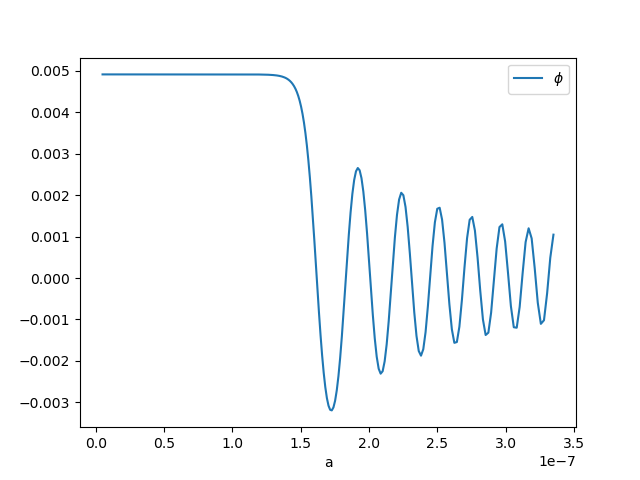

<IPython.core.display.Javascript object>


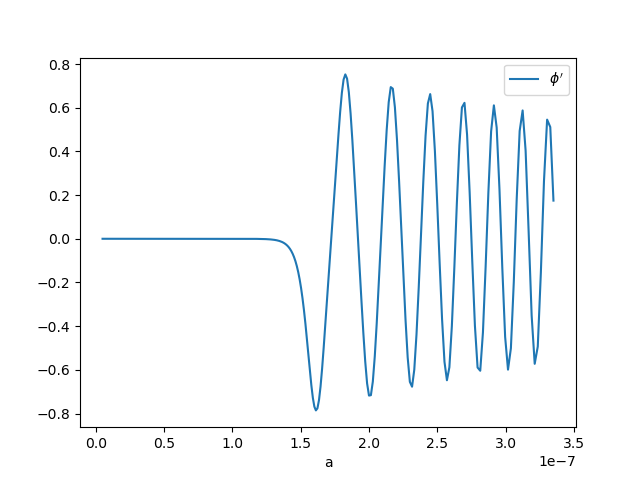

In [13]:
plt.subplots()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('a')
a_list = 1/(1+background['z'])
mask1=a_list > a_crit/10.
mask2=a_list < 7.*a_crit
mask=mask1*mask2
plt.plot(a_list[mask], background['phi_scf'][mask], '-', label=r"$\phi$")
# plt.plot(1/(1+background['z'][mask]), np.abs(background['phi_scf'][mask]), '-', label=r"$\phi$")
plt.legend(loc='best')
#plt.xlim(5e-8, 1e-4)
#plt.ylim(1e4, 1e11)

plt.subplots()
#plt.xscale('log')
plt.xlabel('a')
plt.plot(1/(1+background['z'][mask]), background['phi\'_scf'][mask], '-', label=r"$\phi'$")
plt.legend(loc='best')
#plt.xlim(5e-8, 1e-4)
#plt.ylim(1e4, 1e11)

<IPython.core.display.Javascript object>


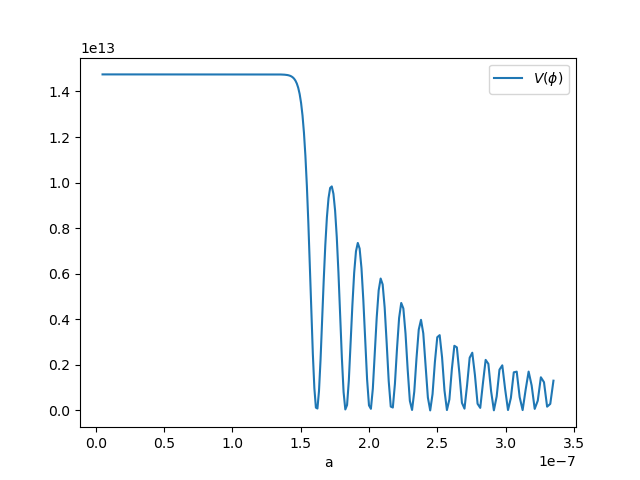

In [14]:
plt.subplots()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('a')

a_list = 1/(1+background['z'])
mask1=a_list > a_crit/10.
mask2=a_list < 7.*a_crit
mask=mask1*mask2
plt.plot(a_list[mask], background['V_scf'][mask], '-', label=r"$V(\phi)$")
plt.legend(loc='best')

<IPython.core.display.Javascript object>


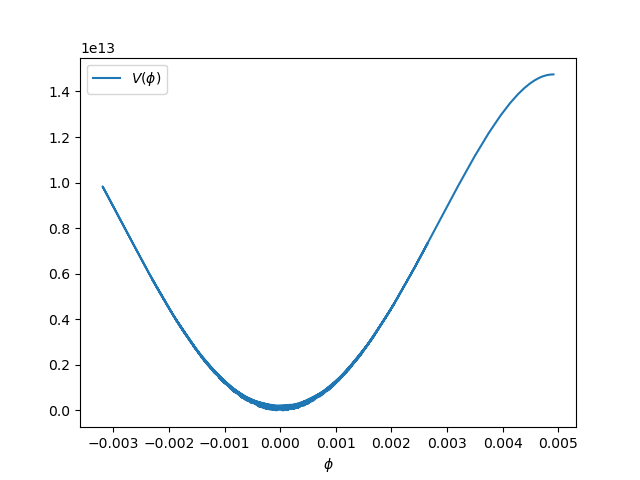

In [15]:
plt.subplots()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('$\phi$')

a_list = 1/(1+background['z'])
mask1=a_list > a_crit/10.
mask2=a_list < 7.*a_crit
mask=mask1*mask2
#plt.plot(a_list[mask], background['V_scf'][mask], '-', label=r"$V(\phi)$")
#plt.plot(a_list[mask], background['phi_scf'][mask], '-', label=r"$V(\phi)$")
plt.plot(background['phi_scf'][mask],background['V_scf'][mask], '-', label=r"$V(\phi)$")
plt.legend(loc='best')

## Perturbation

<IPython.core.display.Javascript object>


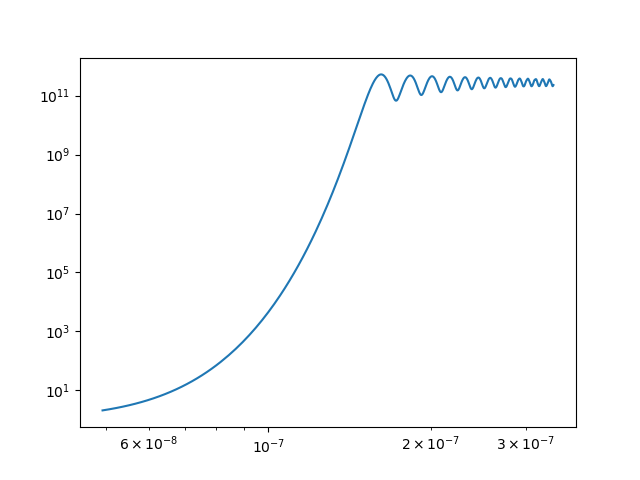

In [16]:
a_list = perturbations['scalar'][0]['a']
mask1=a_list > a_crit
mask2=a_list < 7.*a_crit
mask_pert=mask1*mask2

plt.subplots()
plt.xscale('log')
plt.yscale('log')
plt.plot(perturbations['scalar'][0]['a'][mask_pert], np.abs(perturbations['scalar'][0]['delta_scf'][mask_pert]\
                                                            /perturbations['scalar'][0]['delta_scf'][0]))

In [17]:
# plt.subplots()
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('a')

# a_list = 1/(1+background['z'])
# mask1=a_list > a_crit/10.
# mask2=a_list < 10.*a_crit
# mask=mask1*mask2
# plt.plot(1/(1+background['z'][mask]), background['(.)rho_scf'][mask], '-', label=r"$\rho_{\phi}$")

# for i in range(len(perturbations['scalar'])):
#     a_list = perturbations['scalar'][i]['a']
#     mask1=a_list > 0.1*a_crit
#     mask2=a_list < 7.5*a_crit
#     mask_pert=mask2*mask1
#     plt.plot(perturbations['scalar'][i]['a'][mask_pert], 
#              np.abs(perturbations['scalar'][i]['delta_scf'][mask_pert]/perturbations['scalar'][i]['delta_scf'][0]), 
#              label=r"$\delta_\phi$,k=%g/Mpc"%k_list[i])
# # i=2
# # plt.plot(perturbations['scalar'][i]['a'], 
# #          np.abs(perturbations['scalar'][i]['delta_scf']), 
# #          label=r"$\delta_\phi$,k=%g/Mpc"%k_list[i])

# plt.legend(loc='best')
# #plt.xlim(1e-8, 1e-5)
# #plt.ylim(1e-1, 1e13)

<IPython.core.display.Javascript object>


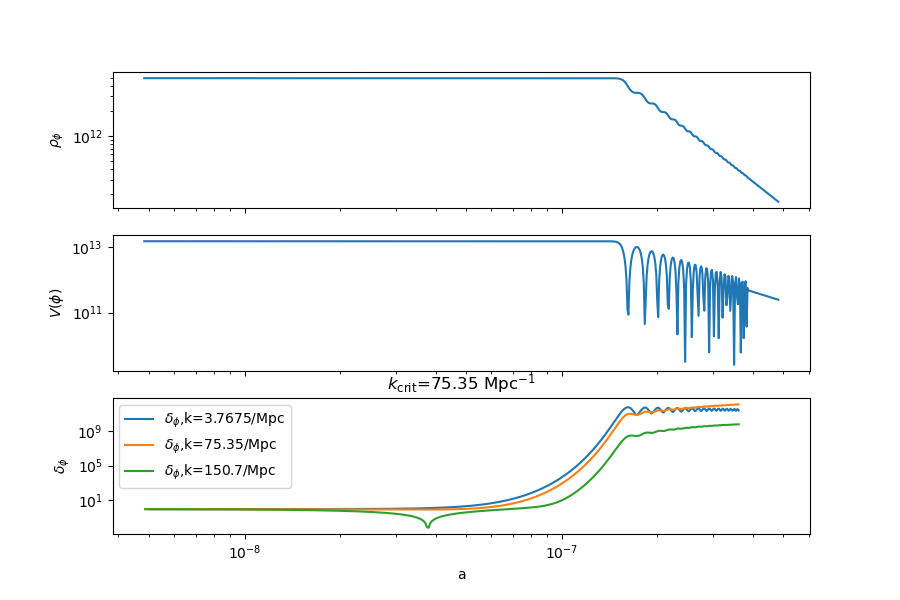

Text(0.5, 1.0, '$k_{\\rm crit}$=75.35 Mpc$^{-1}$')

In [20]:
#_, (ax1, ax2, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,6))
_, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,6))

# plt.subplots()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')

ax1.set_ylabel(r"$\rho_\phi$")
#ax3.set_xlabel('a')
ax2.set_ylabel(r"$V(\phi)$")
ax3.set_ylabel(r"$\delta_\phi$")
ax3.set_xlabel('a')

a_list = 1/(1+background['z'])
mask1=a_list > a_crit/10.
mask2=a_list < 10.*a_crit
mask=mask1*mask2
ax1.plot(1/(1+background['z'][mask]), background['(.)rho_scf'][mask], '-')#, label=r"$\rho_{\phi}$")




ax2.plot(a_list[mask], background['V_scf'][mask], '-')#, label=r"$V(\phi)$")
#plt.legend(loc='best')




for i in range(len(perturbations['scalar'])):
    a_list = perturbations['scalar'][i]['a']
    mask1=a_list > 0.1*a_crit
    mask2=a_list < 7.5*a_crit
    mask_pert=mask2*mask1
    ax3.plot(perturbations['scalar'][i]['a'][mask_pert], 
             np.abs(perturbations['scalar'][i]['delta_scf'][mask_pert]/perturbations['scalar'][i]['delta_scf'][0]), 
             label=r"$\delta_\phi$,k=%g/Mpc"%k_list[i])

ax3.legend(loc='best')
ax3.set_title(r'$k_{\rm crit}$=%.2f Mpc$^{-1}$' %k_crit)



# compare with the enhanced friction

In [ ]:
large_friction_scf = {
    'scf_friction_debug': 5.
}

try:
    cosmo2.struct_cleanup()
except:
    pass
# Create an instance of the CLASS wrapper
cosmo2 = Class()

# Set the parameters to the cosmological code
cosmo2.set(params)
cosmo2.set(settings_scf)
cosmo2.set(large_friction_scf)
cosmo2.compute()

print(cosmo2.age())

In [ ]:
#_, (ax1, ax2, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,6))
_, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,6))

# plt.subplots()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')

ax1.set_ylabel(r"$\rho_\phi$")
#ax3.set_xlabel('a')
ax2.set_ylabel(r"$V(\phi)$")
ax3.set_ylabel(r"$\delta_\phi$")
ax3.set_xlabel('a')

a_list = 1/(1+background['z'])
mask1=a_list > a_crit/10.
mask2=a_list < 10.*a_crit
mask=mask1*mask2
ax1.plot(1/(1+background['z'][mask]), background['(.)rho_scf'][mask], '-')#, label=r"$\rho_{\phi}$")




ax2.plot(a_list[mask], background['V_scf'][mask], '-')#, label=r"$V(\phi)$")
#plt.legend(loc='best')




for i in range(len(perturbations['scalar'])):
    a_list = perturbations['scalar'][i]['a']
    mask1=a_list > 0.1*a_crit
    mask2=a_list < 7.5*a_crit
    mask_pert=mask2*mask1
    ax3.plot(perturbations['scalar'][i]['a'][mask_pert], 
             np.abs(perturbations['scalar'][i]['delta_scf'][mask_pert]/perturbations['scalar'][i]['delta_scf'][0]), 
             label=r"$\delta_\phi$,k=%g/Mpc"%k_list[i])

ax3.legend(loc='best')
ax3.set_title(r'$k_{\rm crit}$=%.2f Mpc$^{-1}$' %k_crit)



In [23]:
background2 = cosmo2.get_background()
perturbations2 = cosmo2.get_perturbations()

z_eq2 = cosmo2.get_current_derived_parameters(['z_eq'])['z_eq']
print("z_eq=%g" %z_eq)

# tau_eq = np.interp(z_eq, background['z'], background['conf. time [Mpc]'])
tau_eq2 = interp1d(background2['z'], background2['conf. time [Mpc]'], kind='cubic')(z_eq2)
print("tau_eq2=%g" %tau_eq2)

# estimate of k_crit

m_Mpc = m*_eV_Mpc_
tau_crit2 = np.sqrt(large_friction_scf['scf_friction_debug']*
                    2./m_Mpc*tau_eq2*(1.+z_eq2))
a_crit2 = np.sqrt(large_friction_scf['scf_friction_debug']*
                  2./(1.+z_eq2)/m_Mpc/tau_eq2)
z_crit2 = 1./a_crit2 - 1.
k_crit2 = m_Mpc * a_crit2
print('k_crit = %g'%(k_crit2))
print('a_crit = %g'%(a_crit2))

z_eq=9645.54
tau_eq2=345.766
k_crit = 168.467
a_crit = 1.07733e-07


<IPython.core.display.Javascript object>


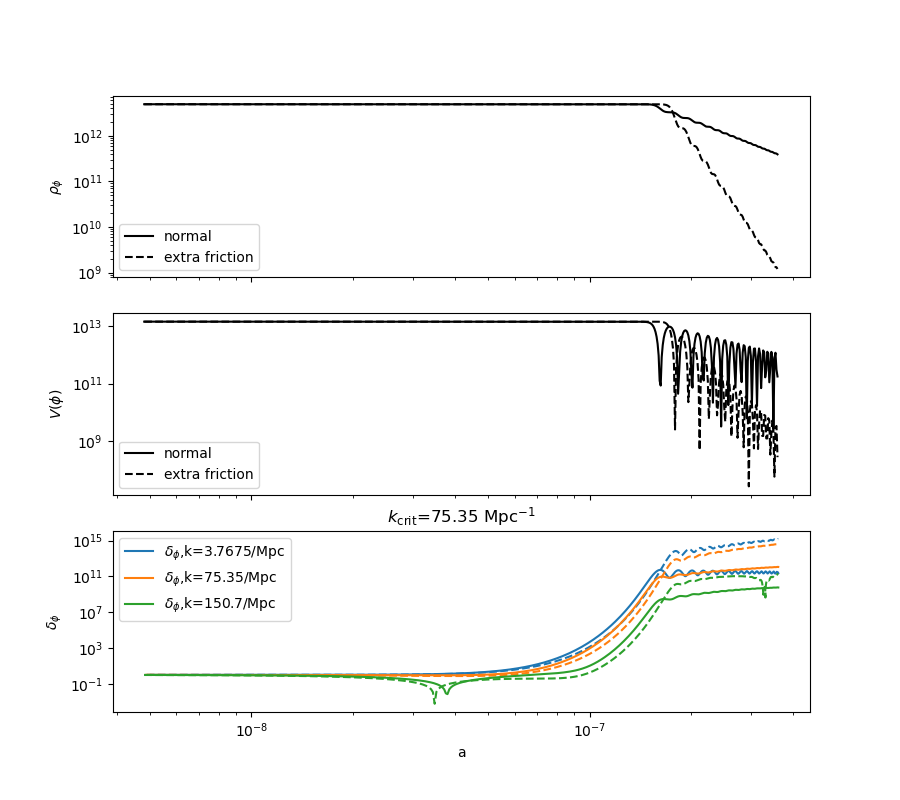

Text(0.5, 1.0, '$k_{\\rm crit}$=75.35 Mpc$^{-1}$')

In [34]:
#_, (ax1, ax2, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9,6))
_, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9,8))

# plt.subplots()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')

ax1.set_ylabel(r"$\rho_\phi$")
#ax3.set_xlabel('a')
ax2.set_ylabel(r"$V(\phi)$")
ax3.set_ylabel(r"$\delta_\phi$")
ax3.set_xlabel('a')

a_list = 1/(1+background['z'])
mask1=a_list > a_crit/10.
mask2=a_list < 7.5*a_crit
mask=mask1*mask2
ax1.plot(1/(1+background['z'][mask]), background['(.)rho_scf'][mask], 'k-', label="normal")#, label=r"$\rho_{\phi}$")
ax1.plot(1/(1+background2['z'][mask]), background2['(.)rho_scf'][mask], 'k--', label="extra friction")#, label=r"$\rho_{\phi}$")
ax1.legend()


ax2.plot(a_list[mask], background['V_scf'][mask], 'k-', label="normal")#, label=r"$V(\phi)$")
ax2.plot(a_list[mask], background2['V_scf'][mask], 'k--', label="extra friction")#, label=r"$V(\phi)$")
#plt.legend(loc='best')
ax2.legend()



for i in range(len(perturbations['scalar'])):
    a_list = perturbations['scalar'][i]['a']
    mask1=a_list > 0.1*a_crit
    mask2=a_list < 7.5*a_crit
    mask_pert=mask2*mask1
    ax3.plot(perturbations['scalar'][i]['a'][mask_pert], 
             np.abs(perturbations['scalar'][i]['delta_scf'][mask_pert]/perturbations['scalar'][i]['delta_scf'][0]), 
             label=r"$\delta_\phi$,k=%g/Mpc"%k_list[i], color="C%d" %i)
    
    a_list = perturbations2['scalar'][i]['a']
    mask1=a_list > 0.1*a_crit
    mask2=a_list < 7.5*a_crit
    mask_pert=mask2*mask1    
    ax3.plot(perturbations2['scalar'][i]['a'][mask_pert], 
             np.abs(perturbations2['scalar'][i]['delta_scf'][mask_pert]/perturbations2['scalar'][i]['delta_scf'][0]), 
             color="C%d" %i, ls='--')

ax3.legend(loc='best')
ax3.set_title(r'$k_{\rm crit}$=%.2f Mpc$^{-1}$' %k_crit)

